In [1]:
%matplotlib inline

## [Partial Dependence plots](https://scikit-learn.org/stable/modules/partial_dependence.html)
- PDPs show the dependence between a target response and a set of "target" features.
- The number of target features should be small (ideally 1-2) to allow for human visualization.


## Example: PDPs, Cal Housing dataset
- Using an [Multilayer Perceptron regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) and [Hist Gradient Boosting regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)
- The target variables are median income (```MedInc```), average occupants per household (```AvgOccup```), median house age (```HouseAge```) and average rooms per household (```AveRooms```).

In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import fetch_california_housing

In [2]:
cal_housing = fetch_california_housing()
X           = pd.DataFrame(cal_housing.data, 
                           columns = cal_housing.feature_names)
y  = cal_housing.target
y -= y.mean()
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1,
                                                    random_state=0)

- The Cal Housing dataset has very different dynamic ranges in it features. Neural nets such as MLPs perform very poorly in this case, if not subject to a preprocessing step.

In [3]:
# PDP for ML perceptron
print("Training MLPRegressor...")
tic = time()
est = make_pipeline(QuantileTransformer(),
                    MLPRegressor(hidden_layer_sizes = (50, 50),
                                 learning_rate_init = 0.01,
                                 early_stopping     = True))
est.fit(X_train, y_train)
print("done in {:.3f}s".format(time() - tic))
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))

Training MLPRegressor...
done in 9.278s
Test R2 score: 0.80


- Find the PDPs for this MLP using a model-agnostic (brute force) method.

Computing partial dependence plots...
done in 3.377s


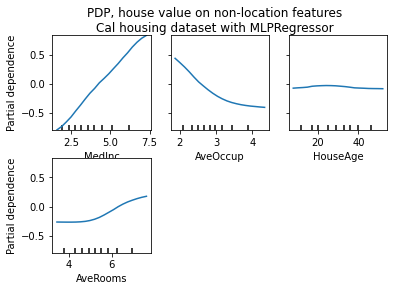

In [5]:
print('Computing partial dependence plots...')
tic = time()
# We don't compute the 2-way PDP (5, 1) here, because it is a lot slower
# with the brute method.
features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms']
plot_partial_dependence(est, 
                        X_train, 
                        features,
                        n_jobs=3, 
                        grid_resolution=20)

print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.suptitle('PDP, house value on non-location features\n'
             'Cal housing dataset with MLPRegressor')
fig.subplots_adjust(hspace=0.3)

- Now fit a GBR model and build the PDPs for either one or two variables at a time.
- Note that we use default parameters for the GBR estimator without preprocessing - tree-based models are naturally robust to numerical feature transforms.

In [6]:
print("Training GradientBoostingRegressor...")
tic = time()
est = HistGradientBoostingRegressor()
est.fit(X_train, y_train)
print("done in {:.3f}s".format(time() - tic))
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))

Training GradientBoostingRegressor...
done in 1.078s
Test R2 score: 0.85


- Note how GBR is significantly faster to train.
- Next, build the PDPs.

Computing partial dependence plots...
done in 1.882s


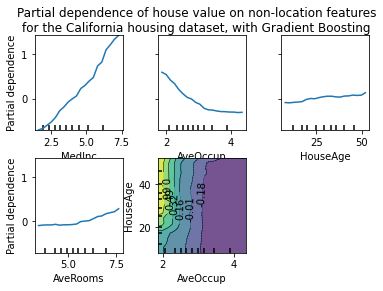

In [7]:
print('Computing partial dependence plots...')
tic = time()
features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms',
            ('AveOccup', 'HouseAge')]
plot_partial_dependence(est, X_train, features,
                        n_jobs=3, grid_resolution=20)
print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.suptitle('Partial dependence of house value on non-location features\n'
             'for the California housing dataset, with Gradient Boosting')
fig.subplots_adjust(wspace=0.4, hspace=0.3)

## Notes:
- median house price has a linear relation to median income. (top left.)
- house price drops as the average occupants per house increases (top middle.)
- house age does not have a strong influence on house pricing. (top right.)
- PDPs with two target features allow human visualization.

## 3D plots
- Same PDP plots for 2 feature interactions, in 3 dimensions.

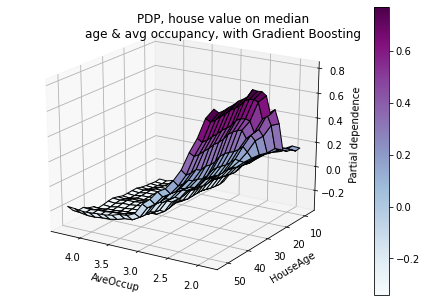

In [8]:
fig = plt.figure()

features = ('AveOccup', 'HouseAge')
pdp, axes = partial_dependence(est, 
                               X_train, 
                               features=features,
                               grid_resolution=20)

XX, YY    = np.meshgrid(axes[0], 
                        axes[1])
Z         = pdp[0].T
ax        = Axes3D(fig)
surf      = ax.plot_surface(XX, YY, Z, rstride=1, 
                            cstride=1,
                            cmap=plt.cm.BuPu, 
                            edgecolor='k')

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, 
             azim=122)
plt.colorbar(surf)
plt.suptitle('PDP, house value on median\n'
             'age & avg occupancy, with Gradient Boosting')
plt.subplots_adjust(top=0.9)

plt.show()